In [1]:
#default_exp data.core

# Data core
> Core data definitions

## TODOs:
* Dont implement Annotation as Tuple
* Dispatch it on transform

In [2]:
#export
from mantisshrimp.all import *
from mantisshrimp.data.load import Bucket # TODO: Fix imports

In [3]:
#export
# Might be better to custom dispatch annotation, because of recursive tuple problem
# TODO: Dispatch transforms... Can this class inherit from tuple?
# Does it needed to be converted to TensorAnnotation?
# Why is area being converted to BBox??
class Annotation:
    keys = 'labels,boxes,area,masks,iscrowd,scores'.split(',') # TODO: Auto insert key in create and d
#     @classmethod
    def __init__(self, labels=None, boxes=None, masks=None, iscrowd=0, area=None, scores=None):
        area = boxes.area if (boxes is not None and area is None) else area
        self.d = dict(labels=labels,boxes=boxes,area=area,masks=masks,iscrowd=iscrowd,scores=scores)
#     @property
#     def d(self): return {k:v for k,v in zip(self.keys,self)}
    def __getitem__(self, name): return self.d.__getitem__(name)
    def __setitem__(self, n, v): return self.d.__setitem__(n, v)
    def __contains__(self, k): return k in self.d
    def __repr__(self): return self.d.__repr__()
    def to_tensor(self): return type(self)(**{k:ToTensor()(v) for k,v in self.d.items()})
    def to_device(self, device): return type(self)(**{k:to_device(v) for k,v in self.d.items()})
    def show(self, ctx, **kwargs):
        for o in self.d.values(): ctx = getattr(o,'show',noop)(ctx, **kwargs)
        return ctx
    
    @classmethod
    def from_dict(cls, d): 
        boxes = d.pop('boxes', None)
        masks = d.pop('masks', None)
        if boxes is not None: boxes = TensorBBox(boxes)
        if masks is not None: masks = TensorMaskBinary(masks)
        return cls(boxes=boxes, masks=masks, **d)

In [4]:
#export
@ToTensor
def encodes(self, o:Annotation): return o.to_tensor()

In [5]:
#export
@patch_property
def area(self:TensorBBox):
    assert len(self.shape) == 2
    b = self
    return ((b[:,3]-b[:,1])*(b[:,2]-b[:,0])).data

In [6]:
#export
@patch_to(TensorBBox, cls_method=True)
def from_mask(cls:TensorBBox, mask):
    boxes = []
    for m in mask:
        v = m.nonzero().T
        vmin,vmax = v.min(1)[0].tolist(),v.max(1)[0].tolist()
        boxes.append([*vmin[::-1], *vmax[::-1]])
    return cls(boxes)

In [7]:
#export
class PILMaskBinary(PILMask):
    @classmethod
    def create(cls, fn): return cls(super().create(fn))

In [8]:
#export
class TensorMaskBinary(TensorMask):
    def show(self, ctx=None, **kwargs):
        mask = (self.squeeze() * torch.arange(1,len(self)+1).to(self.device).view(-1,1,1)).sum(0)
        return TensorMask(mask).show(ctx, **kwargs)

In [9]:
#export
@ToTensor
def encodes(self, o:PILMaskBinary):
    mask_arr = np.array(o)
    obj_ids = np.unique(mask_arr)[1:] # TODO: Hardcoded removal
    return TensorMaskBinary(mask_arr==obj_ids[:,None,None])

In [10]:
source = Path('samples')

In [11]:
im = PILImage.create(source/'im.png')
mask = PILMaskBinary.create(source/'mask.png')

In [12]:
tmask = ToTensor()(mask)

In [13]:
bbox = TensorBBox.from_mask(tmask)
labels = torch.ones(len(tmask))

In [14]:
anot = Annotation(labels=labels, boxes=bbox, masks=mask)

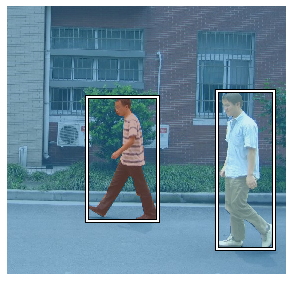

In [15]:
ax = im.show()
anot.show(ax)

## Patches

In [16]:
#export
_old_all_tensors = GatherPredsCallback.all_tensors
@patch
def all_tensors(self:GatherPredsCallback):
    res = _old_all_tensors(self)
    if not self.save_preds:
        pred_i = 1 if self.with_input else 0
        res[pred_i] = Bucket((Annotation.from_dict(res[pred_i]),))
    return res

## Show methods

In [17]:
#export
@typedispatch
def show_batch(x:TensorImage, y:Annotation, samples, ctxs=None, max_n=10, nrows=None, ncols=None, figsize=None, **kwargs):
    if ctxs is None: ctxs = get_grid(min(len(samples), max_n), nrows=nrows, ncols=ncols, figsize=figsize)
    for i,ctx in enumerate(ctxs):
        for s in samples[i]: ctx = s.show(ctx, **kwargs)
    return ctxs

Test show batch

## Export

In [19]:
from nbdev.export import notebook2script
notebook2script()

Converted 00_core.ipynb.
Converted 03_data.load.ipynb.
Converted 04_data.core.ipynb.
Converted index.ipynb.
